In [1]:
%run -i setup


IPython CPU timings (estimated):
  User   :      98.10 s.
  System :       0.00 s.
Wall time:      98.10 s.


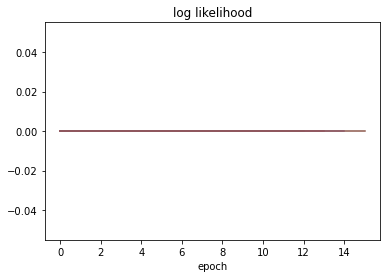

In [2]:
%run -i -t train

In [77]:
#stims=np.random.poisson(lam=stims)
#np.random.seed(255)
#myarray=np.array([[4,4,4],[5,5,5]])
#np.random.poisson(myarray)
#stats.poisson.rvs(myarray)

from scipy.io import loadmat
mypstims = loadmat('mypstims.mat')
mypstims = np.array(mypstims['mypstims'],dtype=float)
#print(mypstims)

myv=loadmat('myv.mat')
myv=np.array(myv['myv'],dtype=float)
#print(myv)

In [85]:
stims=np.zeros((np.sum(g.NV),N_vects), dtype=np.float)
w=g.allW()
bh=g.allBh()
bv=g.allBv()

for i in np.arange(N_vects):
    np.random.seed(255)
    pH= g.NeuronInfo[1].min+np.multiply((g.NeuronInfo[1].max-g.NeuronInfo[1].min),np.random.rand(2))
    
    np.random.seed(255)    
    if np.random.rand()>pCouple:
        np.random.seed(255)
        pBc=g.NeuronInfo[0].min-.15+ np.multiply((.3+g.NeuronInfo[0].max-g.NeuronInfo[0].min),np.random.rand(2))
    else:
        np.random.seed(255)
        pBc=pH+.15*norm.ppf(np.random.rand(2))
    np.random.seed(255)
    gains=4+6*np.random.rand(3)
    Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
    stims[:,i]=np.concatenate((Bc, H, T), axis=None)
        
np.random.seed(255)
#stims=np.random.poisson(lam=stims)
#stims=np.random.poisson(stims)
stims=mypstims

gv=w@stims+bh
mu=1.0 / (1.0+np.exp(-gv)) 
mu=mu.conj().T
np.random.seed(255)
rr=np.random.rand(np.shape(mu)[1],np.shape(mu)[0]).T
h=1.0*(rr<mu).conj().T

dW=h@stims.conj().T  
dBv=np.sum(stims,axis=1,keepdims=True)
dBh=np.sum(h,axis=1,keepdims=True)

#down
gv=w.conj().T@h+bv
mu=np.exp(gv)
#np.random.seed(255)
#v=np.random.poisson(lam=mu)
v=myv             

#up
gv=w@v+bh
mu= 1.0 / (1.0+np.exp(-gv)) 
mu=mu.conj().T
np.random.seed(255)
rr=np.random.rand(np.shape(mu)[1],np.shape(mu)[0]).T
h=1.0*(rr<mu).conj().T

dW=dW-h@v.conj().T 
dBv=dBv-np.sum(v,axis=1,keepdims=True)
dBh=dBh-np.sum(h,axis=1,keepdims=True)

#update weights and biases
w=w+eta*dW
bv=bv+eta*dBv
bh=bh+eta*dBh

In [ ]:
## TODO
## Beware randn> https://stackoverflow.com/questions/3722138/is-it-possible-to-reproduce-randn-of-matlab-with-numpy
## Ts and pBcs are not right.
## This happens because w, bh and bv are not right.
## This happens because g is not right. Check out setup and training.
## Setup is alright. Look out for training.  
## Training fails. Look out for set functions.
## Setup W is ok. Setup Bv and Bh are ok. Look for operations in training. 
## Problem was in training pH definition. Fixed. 
## Now, something seems to be wrong in pHs. Also, when seed unfixed the model stops working.
## Problem with first set of matrix operations in training. Why? It was due to np.ppf change of function. 
## Problem with stimgen. Bc and H. T is fine. The problem was Matlab's (:) flattens in Fortran order, which is achieved by np.ravel(Order='F)
## Problem with stims poisson generated. Matlab and Python implementation differ: https://hpaulkeeler.com/simulating-poisson-random-variables-survey-methods/
## Besides poisson implementation, h is failing. It was due to rand matrix ordering. 

<Figure size 432x288 with 0 Axes>

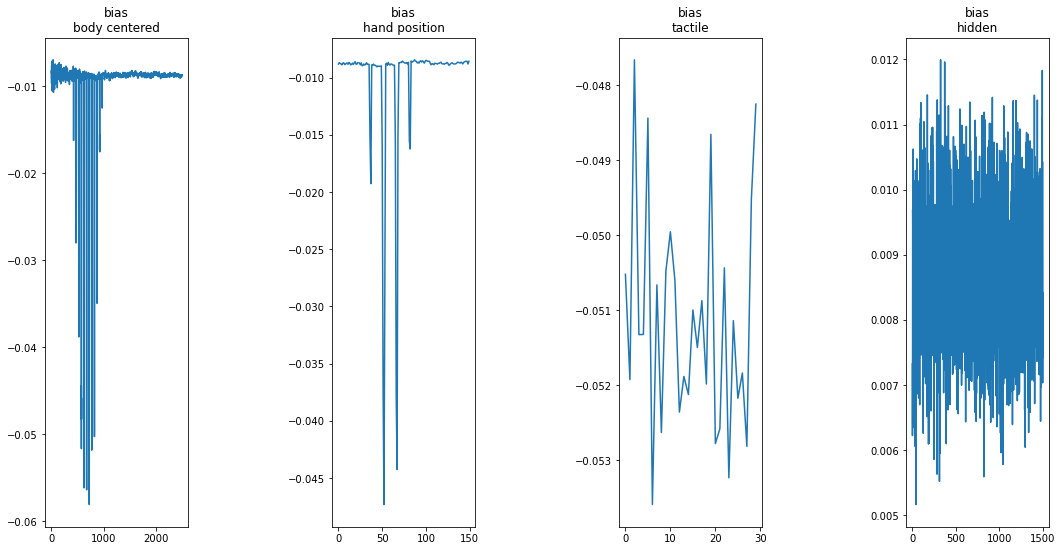

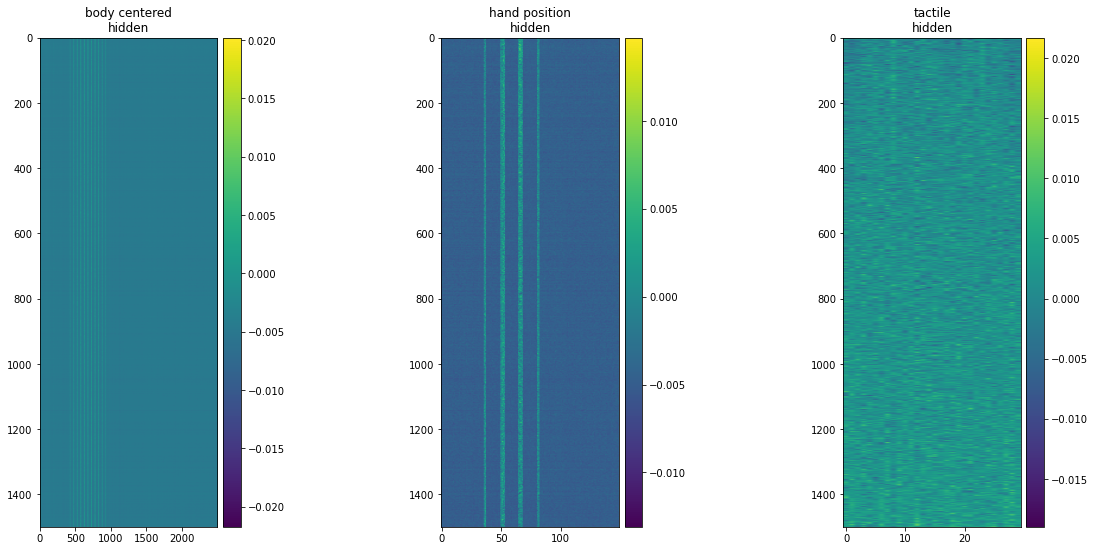

In [3]:
myw,myor = g.showPars(True)

In [4]:
## hand centered vs body centered tactile evoked activity

ntrials=10000
N_vects=100
ntrials=int(np.round(ntrials/N_vects)*N_vects)

nsteps=1
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,2))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros(ntrials)
nGridPoints=17
stims=np.zeros((np.sum(g.NV),N_vects),dtype=float)
count=0
w=g.allW()
bh=g.allBh()
bv=g.allBv()
for i in np.arange( int(np.round(ntrials/N_vects)) ):
    if (i%10)==0:print(i)
    
    for v in np.arange(N_vects):
        count=count+1
        pBc=g.NeuronInfo[0].min+np.multiply(g.NeuronInfo[0].max-g.NeuronInfo[0].min,np.random.rand(2))
        pH=g.NeuronInfo[1].min+np.multiply(g.NeuronInfo[1].max-g.NeuronInfo[1].min,np.random.rand(2))
        gains=4+6*np.random.rand(3)
        Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
        T=0*T
        stims[:,v]=np.concatenate((Bc, H, T), axis=None)
        pBcs[count-1,:]=pBc
        pHs[count-1,:]=pH
        pHcs[count-1,:]=pBc-pH
    
    v=stims
    for s in np.arange(nsteps):
        #noiseless up and down passes, since we only care about averages
        #for the plots
        #up
        gv=w@v+bh
        mu=1.0/(1.0+np.exp(-gv))
        mu=mu.conj().T
        h=mu.conj().T
        #down
        gv=w.conj().T@h+bv
        mu=np.exp(gv)
        v=mu
        v[:-g.NV[2],:]=stims[:-g.NV[2],:]
        
    Ts[(i)*N_vects:(i+1)*N_vects] = np.nanmean(v[-g.NV[2]:,:],axis=0) 

0
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:428: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:428: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
10
20
30
40
50
60
70
80
90


In [108]:
## To compare againts matlab original model
#from scipy.io import loadmat
#myTs = loadmat('myTs.mat')
#mypBcs = loadmat('mypBcs.mat')
#mypHcs = loadmat('mypHcs.mat')
#mypHs = loadmat('mypHs.mat')

#Ts = myTs['Ts']
#pBcs = mypBcs['pBcs']
#pHcs = mypHcs['pHcs']
#pHs = mypHs['pHs'] 



[[-0.00467786 -0.00400606 -0.00527493 ... -0.02237463 -0.00614212
  -0.00612527]
 [-0.00441144 -0.00402903 -0.00393503 ... -0.01098937 -0.00348764
  -0.00815389]
 [-0.0032166  -0.002838   -0.00486536 ... -0.00666413  0.0010002
  -0.00456346]
 ...
 [-0.00433763 -0.0042542  -0.00463571 ...  0.01277437  0.00397904
   0.00782675]
 [-0.00454237 -0.00333711 -0.0049209  ...  0.01029587  0.00607046
   0.00756048]
 [-0.00604551 -0.0058247  -0.00549587 ...  0.00920522  0.00787209
   0.00278401]]


c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:458: RuntimeWarning: Mean of empty slice
  grid[i,j]=np.nanmean( z [np.where((indX==(j+1))*(indY==(i+1)))] )
C:\Users\renat\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<Figure size 432x288 with 0 Axes>

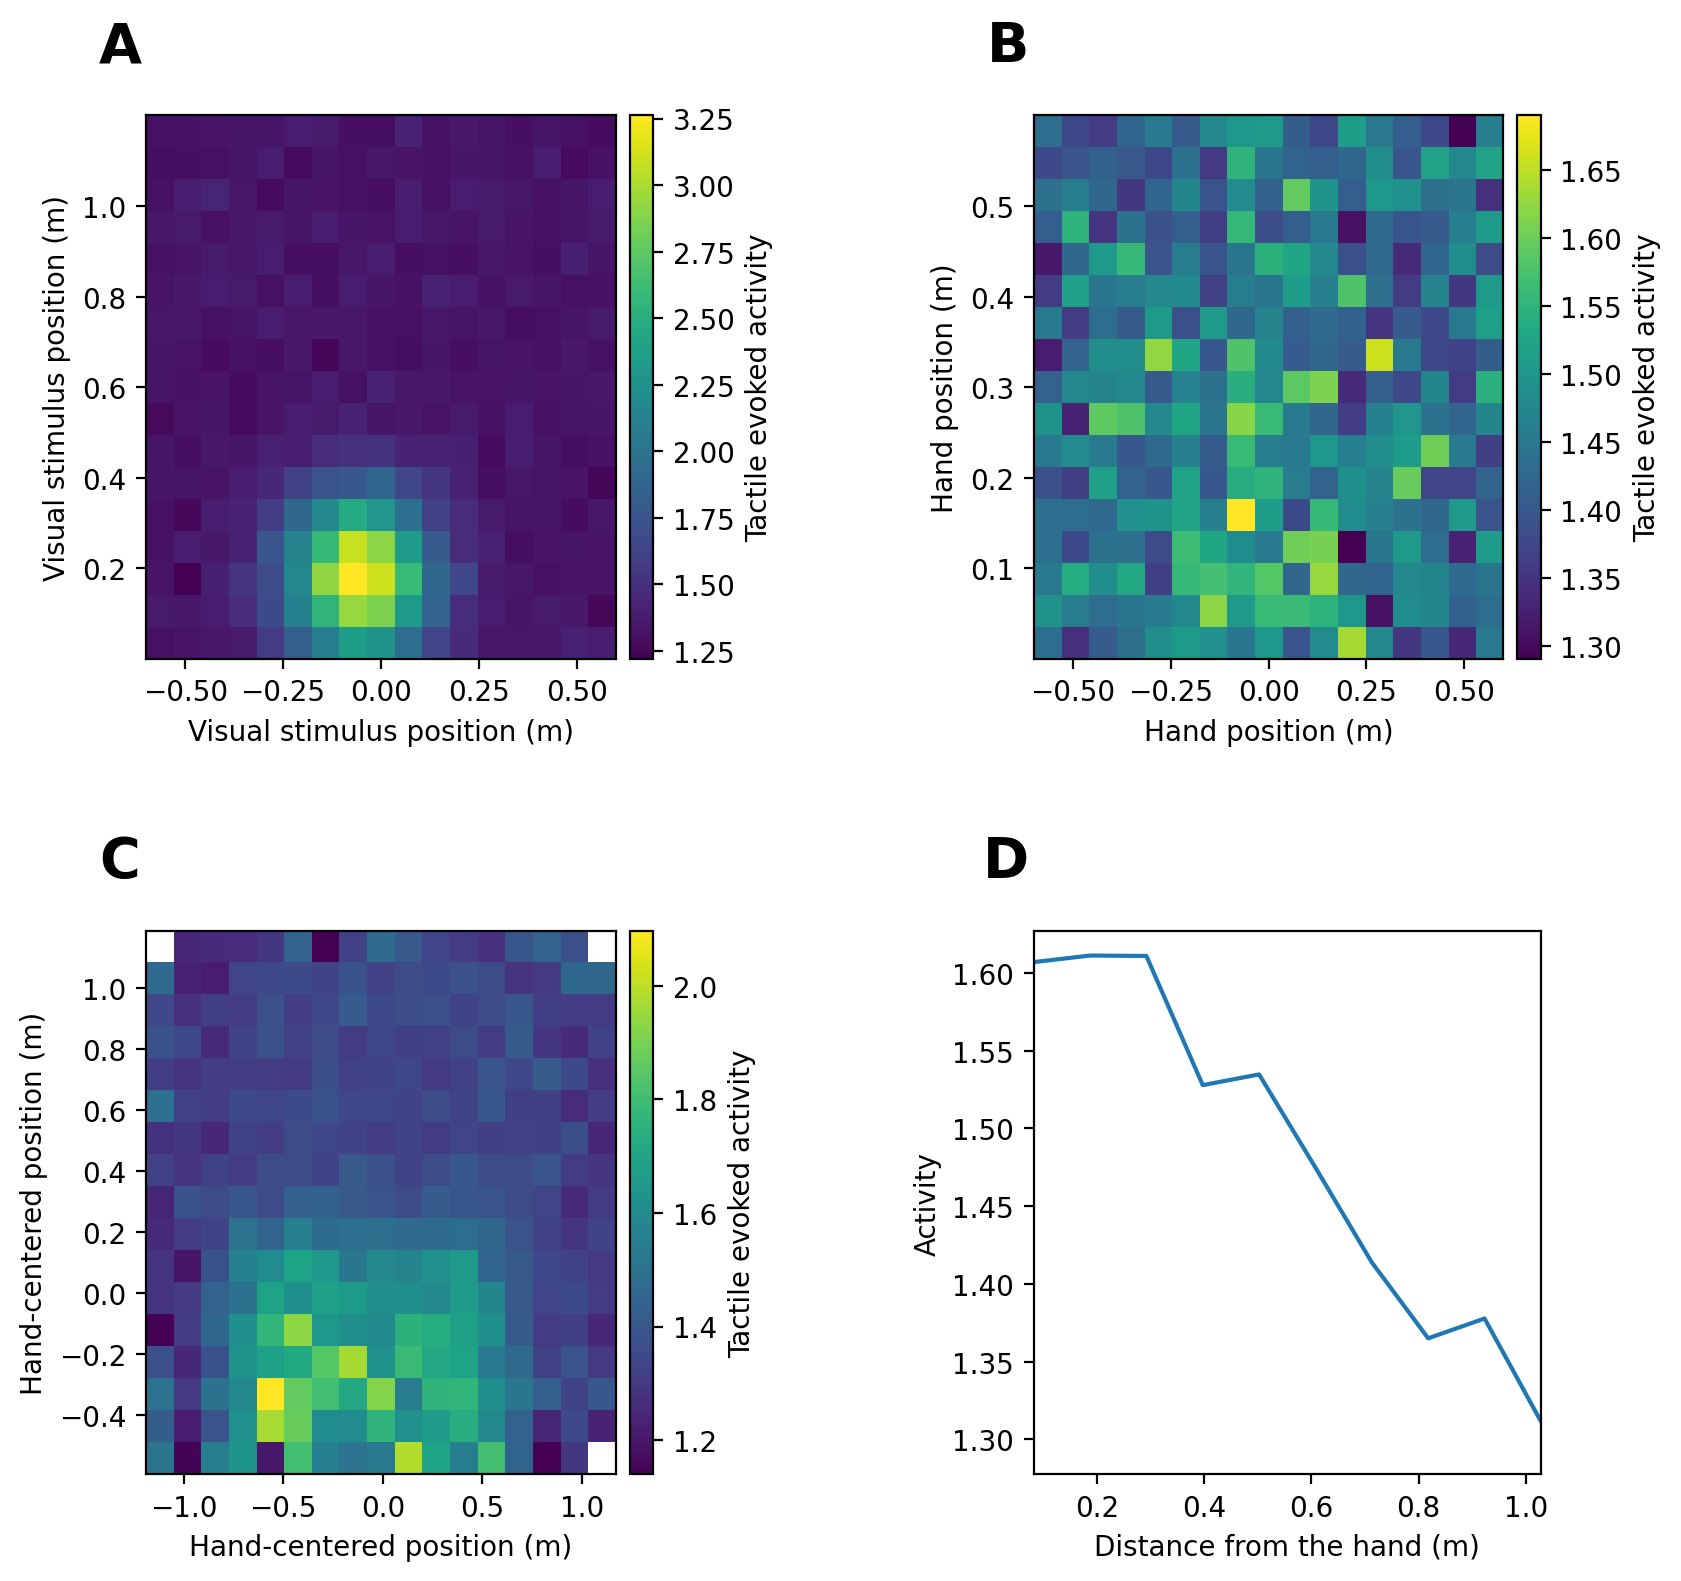

In [5]:
import string
import matplotlib as mpl

def extents(f):
# https://gist.github.com/fasiha/eff0763ca25777ec849ffead370dc907
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

plt.figure(3)

fig, axs = plt.subplots(2, 2, figsize=(9, 9),dpi = 200)
ax1 = plt.subplot(221)
grid,xc,yc,_,_=bindata2d(pBcs[:,0],pBcs[:,1],Ts,nGridPoints)
im1=ax1.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax1.set_xlabel('Visual stimulus position (m)')
ax1.set_ylabel('Visual stimulus position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im1, cax=cax,label='Tactile evoked activity')
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
                size=20, weight='bold')

ax2 = plt.subplot(222)
grid,xc,yc,_,_=bindata2d(pHs[:,0],pHs[:,1],Ts,nGridPoints)
im2=ax2.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax2.set_xlabel('Hand position (m)')
ax2.set_ylabel('Hand position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im2, cax=cax,label='Tactile evoked activity')
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
                size=20, weight='bold')

ax3 = plt.subplot(223)
grid,xc,yc,stds,ns=bindata2d(pHcs[:,0],pHcs[:,1],Ts,nGridPoints)
im3=ax3.imshow(grid, aspect='auto', interpolation='none',
           extent=extents(xc) + extents(yc), origin='lower')
ax3.set_xlabel('Hand-centered position (m)')
ax3.set_ylabel('Hand-centered position (m)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im3, cax=cax,label='Tactile evoked activity')
ax3.text(-0.1, 1.1, string.ascii_uppercase[2], transform=ax3.transAxes, 
                size=20, weight='bold')

ax4=plt.subplot(224)
xgrid,ygrid=np.meshgrid(xc,yc)
distances=np.ravel(xgrid,order='F')**2+np.ravel(ygrid,order='F')**2
xx,yy,_,sem = bindata(distances,grid.ravel(order='F'),numbins=20)
ax4.plot(xx,yy) # TODO complete: plot(xx,yy,'LineWidth',2)
ax4.set_xlabel('Distance from the hand (m)')
ax4.set_ylabel('Activity')

minInd=np.argmin(np.abs(xx))
maxInd=np.argmin(np.abs(xx-1))
ax4.set_xlim([xx[minInd],xx[maxInd]])
ax4.text(-0.1, 1.1, string.ascii_uppercase[3], transform=ax4.transAxes, 
                size=20, weight='bold')

fig.subplots_adjust(wspace=0.75)      
fig.subplots_adjust(hspace=0.5)                

c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: overflow encountered in exp
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
c:\Users\renat\PhD\RHI\SCZ_RHI_RBM\Dev\GRBM.py:427: RuntimeWarning: invalid value encountered in double_scalars
  elambda = 1.0 -np.exp(slope*(d-dCp))/(1.0 +np.exp(slope*(d-dCp)))
train.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  #res[epoch]=re/(dE*N_batches)
train.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior 

<Figure size 432x288 with 0 Axes>

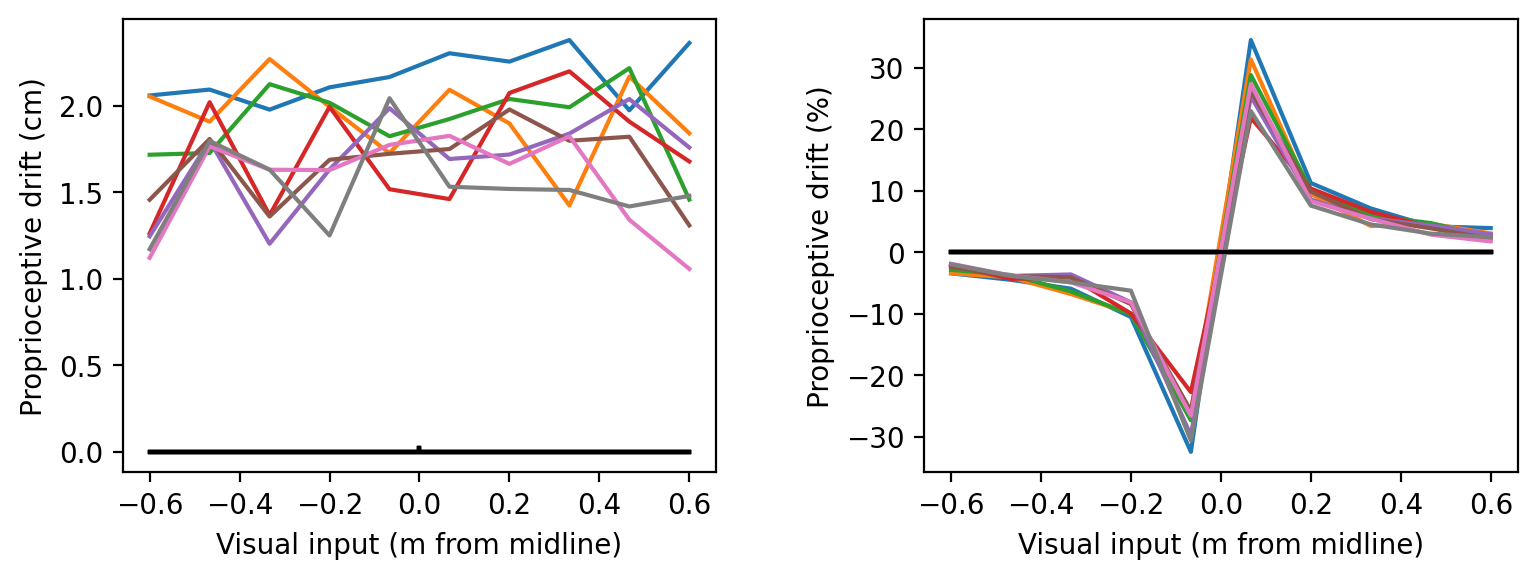

In [16]:
## proprioceptive drift
nPos=10
nRep=500
ntrials=nPos*nRep
nsteps=1
NV=g.NV
pBcs=np.zeros((ntrials,2))
pHs=np.zeros((ntrials,1))
pHcs=np.zeros((ntrials,2))
Ts=np.zeros((ntrials,1))
rBcs=np.zeros((g.NV[0],ntrials))
rHs=np.zeros((g.NV[1],ntrials))

positions=np.linspace(g.NeuronInfo[0].min[0],g.NeuronInfo[0].max[0],nPos)
tStrengths=np.concatenate((0,np.arange(4,10+1)),axis=None)
maxPDs=np.zeros(np.size(tStrengths))
#colours=[0,0,0;jet( np.size(tStrengths-1) )]
tFlag=Ts
pH=[0,0.25]

plt.figure(4)
fig, axs = plt.subplots(1, 2, figsize=(9, 3),dpi = 200)

for ts in np.arange(np.size(tStrengths)):
    tStrength=tStrengths[ts]
    count=0
    for p in np.arange(nPos):
        stims=np.zeros((np.sum(g.NV),nRep)) #again stimuli are noiseless since we only care about averages here
        for r in np.arange(nRep):
            count=count+1
            y=.6*np.random.rand()
            pBc=np.array([positions[p],y])
            pH=np.array([0,y])
            gains=4+6*np.random.rand(3,1)
            Bc,H,T=stimgen(pBc,pH,g.NeuronInfo,gains)
            T=tStrength+0*T
            stims[:,r]=np.concatenate((Bc, H, T), axis=None)
            pBcs[count-1,:]=pBc
            pHs[count-1]=pH[0]
            pHcs[count-1,:]=pBc-pH
        
        for s in np.arange(nsteps):
            h,mymu=g.fastUp(stims)
            v,mymu=g.fastDown(h)
            stims[g.NV[0]:g.NV[0]+g.NV[1],:]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        cols=np.arange(nRep)+(p)*nRep
        #cols=np.arange(nRep+1)+(p)*nRep
        rHs[:,cols]=v[g.NV[0]:g.NV[0]+g.NV[1],:]
        rBcs[:,cols]=v[:g.NV[0],:]
    
    touchedH=np.zeros((g.NV[1],nPos))
    nTouchedH=touchedH
    touchedBc=np.zeros((g.NV[0],nPos))
    nTouchedBc=touchedBc
    m=np.ceil(np.sqrt(nPos))
    n=np.round(nPos/m)
    tp=np.zeros((nRep,nPos))
    ntp=[]
    wx,wy=np.meshgrid(np.arange(g.NeuronInfo[1].n[0],dtype=float),np.arange(g.NeuronInfo[1].n[1],dtype=float))
    #wx,wy=np.meshgrid(np.arange(g.NeuronInfo[1].n[0]+1,dtype=float),np.arange(g.NeuronInfo[1].n[1]+1,dtype=float))
    
    for p in np.arange(nPos):
        cols=np.arange(nRep)+(p)*nRep
        #cols=np.arange(nRep+1)+(p)*nRep
        touchedH[:,p]=np.nanmean(rHs[:,cols],1)
        touchedBc[:,p]=np.mean(rBcs[:,cols],1)
        hCurr=rHs[:,cols]
        
        for i in np.arange(np.shape(hCurr)[1]):
            w=np.flipud(np.rot90(np.reshape(hCurr[:,i],g.NeuronInfo[1].n)))
            barX=np.sum(np.multiply(w,wx))/np.sum(w)
            barY=np.sum(np.multiply(w,wy))/np.sum(w)
            tp[i,p]=barX
        
    ax1=plt.subplot(121)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp)[0]))
    y=indToPos(np.array([np.nanmean(tp,axis=0),0*np.nanmean(tp,axis=0)]).T,g.NeuronInfo[1]) #double check the output of indToPos. 
    y=y[:,0].conj().T
    maxPDs[ts]=np.max(y)
    ax1.plot(positions, 100*y) #, 'LineWidth',2,'color',colours(ts,:));
    ax1.plot(positions,np.zeros(np.shape(positions)),'k')    #'--','LineWidth',2,'color','k')
    ax1.plot([0,0],[np.min(y),np.max(y)],'k') #,'--','LineWidth',2,'color','k')
    ax1.set_xlabel('Visual input (m from midline)')
    ax1.set_ylabel('Proprioceptive drift (cm)')
    
    ax2=plt.subplot(122)
    err=g.NeuronInfo[1].span[0]*np.nanstd(tp)/(g.NeuronInfo[1].n[0]*np.sqrt(np.shape(tp)[0]))
    y=indToPos(np.array([np.nanmean(tp,axis=0),0*np.nanmean(tp,axis=0)]).T,g.NeuronInfo[1])
    y=y[:,0].conj().T
    ax2.plot(positions,100*(y/positions)) # ,'LineWidth',2,'color',colours(ts,:));
    ax2.plot(positions,np.zeros(np.shape(positions)),'k') #'--','LineWidth',2,'color','k')
    ax2.plot([0,0],[np.min(y),np.max(y)],'k') #'--','LineWidth',2,'color','k')
    ax2.set_xlabel('Visual input (m from midline)')
    ax2.set_ylabel('Proprioceptive drift (%)')
    
fig.subplots_adjust(wspace=0.35)      
plt.show()

In [12]:
""" import pickle
with open('trained.pkl', 'wb') as output:
    pickle.dump(g, output, pickle.HIGHEST_PROTOCOL) """

" import pickle\nwith open('trained.pkl', 'wb') as output:\n    pickle.dump(g, output, pickle.HIGHEST_PROTOCOL) "